<a href="https://colab.research.google.com/github/tillaczel/Machine-learning-workshop/blob/resturcture/Keras_basics/Cancer_exercise_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting probability of cancer
In this notebook your task is to build a model, which can predict the probability of cancer given a sample.
All code is complete except the build_model() function.

## Install and import
First let's upgrade tensorflow to 2.0, then import all the nescecary libraries.

In [0]:
!pip install tensorflow --upgrade

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.utils import shuffle

     |████████████████████████████████| 86.3MB 40kB/s 
     |████████████████████████████████| 450kB 47.5MB/s 
     |████████████████████████████████| 3.8MB 50.2MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalle

## Importing and understanding the dataset

We are using the breast cancer dataset from sklearn.
The description of the dataset is printed out.

In [0]:
dataset = load_breast_cancer()
print(dataset.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

## Prepare data

To avoid bias in the training data, the data needs to be shuffled before the train validation split. We are using a 80% validation split.

In [0]:
x, y = shuffle(dataset.data, dataset.target, random_state=1)

train_ratio = 0.8
x_train, y_train = x[:int(train_ratio*len(x))], y[:int(train_ratio*len(y))]
x_test, y_test = x[int(train_ratio*len(x)):], y[int(train_ratio*len(y)):]

After printing out the dataset it can be seen, that the input needs to be normalized.

In [0]:
print(x_train)
print(y_train)

[[1.469e+01 1.398e+01 9.822e+01 ... 1.108e-01 2.827e-01 9.208e-02]
 [1.317e+01 1.866e+01 8.598e+01 ... 2.088e-01 3.900e-01 1.179e-01]
 [1.295e+01 1.602e+01 8.314e+01 ... 1.056e-01 3.380e-01 9.584e-02]
 ...
 [8.734e+00 1.684e+01 5.527e+01 ... 0.000e+00 2.445e-01 8.865e-02]
 [1.877e+01 2.143e+01 1.229e+02 ... 2.048e-01 3.679e-01 9.870e-02]
 [1.127e+01 1.296e+01 7.316e+01 ... 1.318e-01 3.343e-01 9.215e-02]]
[1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0
 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0
 1 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1
 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0
 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 

To avoid information leakage, the mean and standard deviation for the normalization needs to be calculated only on the training dataset. For numerical stability 1e+6 is added to the standard deviation.

In [0]:
mean = np.mean(x_train)
std = np.std(x_train)

x_train_norm, x_test_norm = (x_train-mean)/(std+1e-6), (x_test-mean)/(std+1e-6)

In [0]:
print(x_train_norm)

[[-0.20671989 -0.20983555  0.15983156 ... -0.27069722 -0.26994288
  -0.27077937]
 [-0.21339004 -0.18929849  0.10611925 ... -0.27026717 -0.26947202
  -0.27066607]
 [-0.21435546 -0.2008835   0.09365659 ... -0.27072004 -0.26970021
  -0.27076287]
 ...
 [-0.23285637 -0.19728513 -0.02864425 ... -0.27118344 -0.27011051
  -0.27079442]
 [-0.18881578 -0.17714301  0.26813385 ... -0.27028473 -0.269569
  -0.27075032]
 [-0.22172774 -0.21431158  0.04986174 ... -0.27060507 -0.26971645
  -0.27077906]]


## Task

Complete the build_model() function!

In [0]:
def build_model(x_train_norm, y_train, x_test_norm, y_test):
    model = Sequential()
    model.add(Dense(128, input_dim=30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = optimizers.Adam(lr=0.001)

    model.compile(optimizer=optimizer,
                loss='mse',
                metrics=['accuracy'])

    history = model.fit(x_train_norm, y_train, validation_data=(x_test_norm, y_test), epochs=100, batch_size=32)
    return model, history

In [0]:
model, history = build_model(x_train_norm, y_train, x_test_norm, y_test)

Train on 455 samples, validate on 114 samples
Epoch 1/100
455/455 [==============================] - 1s 1ms/sample - loss: 0.1836 - accuracy: 0.8352 - val_loss: 0.1510 - val_accuracy: 0.8596
Epoch 2/100
455/455 [==============================] - 0s 110us/sample - loss: 0.1334 - accuracy: 0.8923 - val_loss: 0.1154 - val_accuracy: 0.8684
Epoch 3/100
455/455 [==============================] - 0s 92us/sample - loss: 0.1079 - accuracy: 0.8945 - val_loss: 0.0963 - val_accuracy: 0.8772
Epoch 4/100
455/455 [==============================] - 0s 92us/sample - loss: 0.0939 - accuracy: 0.9121 - val_loss: 0.0857 - val_accuracy: 0.8947
Epoch 5/100
455/455 [==============================] - 0s 108us/sample - loss: 0.0860 - accuracy: 0.9011 - val_loss: 0.0786 - val_accuracy: 0.9035
Epoch 6/100
455/455 [==============================] - 0s 102us/sample - loss: 0.0805 - accuracy: 0.9143 - val_loss: 0.0735 - val_accuracy: 0.9035
Epoch 7/100
455/455 [==============================] - 0s 104us/sample - los

## Training visualization

To spot over and underfitting, the training and validation loss and accuracy are plotted.

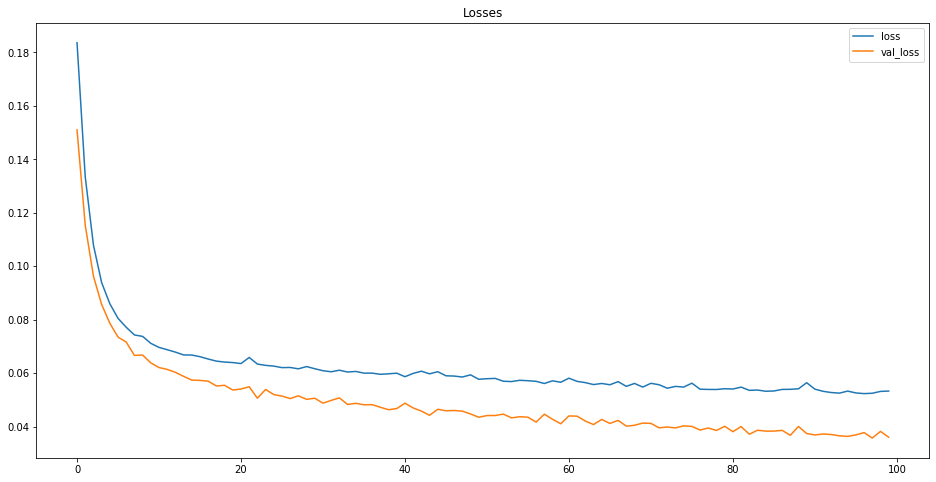

In [0]:
fig = plt.figure(figsize=(16,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Losses')
plt.show()

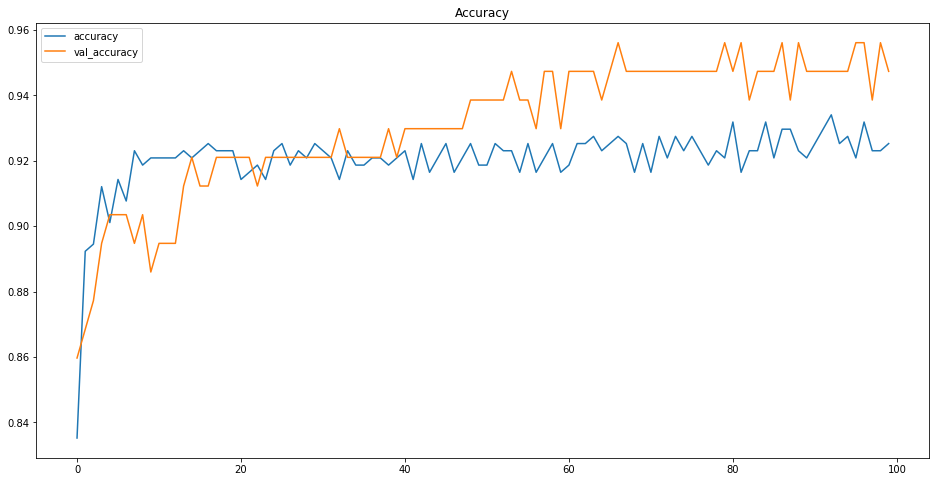

In [0]:
fig = plt.figure(figsize=(16,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.show()

## Validation

The task is to maximize the accuracy on the validation dataset.

In [0]:
decision_boundary = 0.5

prediction = np.round(model.predict(x_test_norm)[:,0]+0.5-decision_boundary,0).astype(int)

accuracy = (np.sum(np.multiply(prediction==1, y_test==1))+np.sum(np.multiply(prediction==0, y_test==0)))/len(y_test)

print(f'accuracy: {accuracy}')

accuracy: 0.9473684210526315
